1. 导入依赖

In [5]:
from CliffWalking import CliffWalkingEnv,HashPosition
from RL_Solver_Class import Sarsa,ExpectedSarsa,Nstep_SARSA,NstepSarsa_Off_policy,Q_learning
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
# 用来设置一个 episode 的最⼤步数限制（step 数）。超过限制就自动终止 episode，返回 truncated = True。
from gym.wrappers import TimeLimit

2. 定义最优策略打印函数

In [6]:
def print_final_policy(agent, env, action_meaning, disaster=[], end=[]):
    """
    打印最终策略图，每个格子固定5字符宽度，整齐显示。
    """
    if not agent.policy_is_updated:
        agent.update_policy()

    for i in range(env.nrow):
        for j in range(env.ncol):
            s = i * env.ncol + j
            if s in disaster:
                print('****'.ljust(5), end=' ')
            elif s in end:
                print('EEEE'.ljust(5), end=' ')
            else:
                greedy_actions = agent.greedy_policy[s]
                action_str = ''
                for a in range(agent.n_action):
                    if a < len(action_meaning):
                        action_str += action_meaning[a] if a in greedy_actions else 'o'
                    else:
                        action_str += 'o'
                print(action_str.ljust(5), end=' ')
        print()  # 换行

3. Sarsa进行训练（学习率和探索率动态调整）

Iteration 0: 100%|██████████| 10/10.0 [00:00<00:00, 19.72it/s, episode=10, return=-277.300]
Iteration 1: 100%|██████████| 10/10.0 [00:00<00:00, 20.07it/s, episode=110, return=-278.800]
Iteration 2: 100%|██████████| 10/10.0 [00:00<00:00, 22.58it/s, episode=210, return=-206.000]
Iteration 3: 100%|██████████| 10/10.0 [00:00<00:00, 24.11it/s, episode=310, return=-122.300]
Iteration 4: 100%|██████████| 10/10.0 [00:00<00:00, 21.70it/s, episode=410, return=-128.700]
Iteration 5: 100%|██████████| 10/10.0 [00:00<00:00, 24.14it/s, episode=510, return=-96.000]
Iteration 6: 100%|██████████| 10/10.0 [00:00<00:00, 24.55it/s, episode=610, return=-145.400]
Iteration 7: 100%|██████████| 10/10.0 [00:00<00:00, 25.84it/s, episode=710, return=-115.700]
Iteration 8: 100%|██████████| 10/10.0 [00:00<00:00, 23.45it/s, episode=810, return=-77.800]
Iteration 9: 100%|██████████| 10/10.0 [00:00<00:00, 25.99it/s, episode=910, return=-136.900]
Iteration 10: 100%|██████████| 10/10.0 [00:00<00:00, 24.25it/s, episode=1

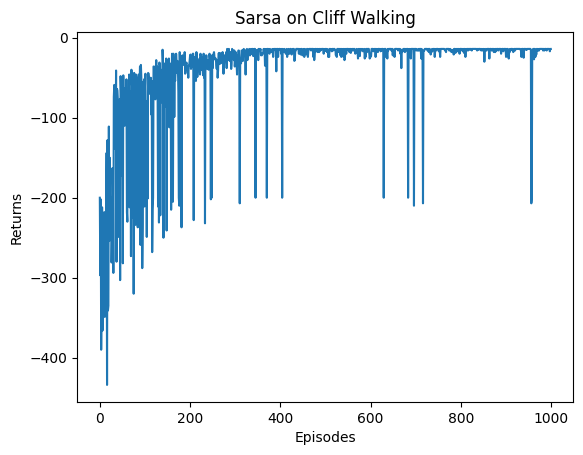


Sarsa算法最终收敛的贪婪策略为：
ooo>o ooo>o ^oooo ^oooo ooo>o ooo>o ^oooo ^v<>x ovooo ooo>o ooo>o ^v<>x 
ooo>o ooo>o ^oooo ^v<>x ovooo ooo>o ^oooo ^v<>x ooo>o ooo>o ^oooo ^v<>x 
ooo>o ooo>o oooox ^v<>x ooo>o ooo>o ooo>o ^v<>x ovooo ooo>o ooo>o ^v<>x 
ovooo ****  ****  ****  ****  ****  ****  ****  ****  ****  ****  EEEE  


In [7]:
# env实例化
env = CliffWalkingEnv(render_mode='human', map_size=(4, 12), pix_square_size=30)
env.action_space.seed(100)  # 设置随机种子
state, info = env.reset(seed=100)  # 重置环境，返回初始状态和信息
wrapper_env = TimeLimit(env, max_episode_steps=500)  # 设置最大步数限制
wrapper_env = HashPosition(wrapper_env)  # 使用哈希位置包装器将二维状态转化为一维状态

epsilon = 0.1           # 初始探索率
alpha = 0.1             # 初始学习率
agent = Sarsa(wrapper_env, alpha=alpha, gamma=0.9, epsilon=epsilon, seed=42)  # 创建Sarsa智能体

num_episodes = 1000  # 设置训练的总回合数
num_period = 100  # 设置轮数
#  SARSA 算法本身内部有折扣因子 γ,γ 的影响体现在 Q 表的更新中；
return_list = []  # 用于存储每个周期的平均回报,回报G_t(G_t = r_t +r_{t+1} + ... +r_T)

 # 分轮完成训练，每轮结束后统计该轮平均回报 
for i in range(num_period):
    # tqdm的进度条功能
    with tqdm(total = num_episodes / num_period, desc='Iteration %d' % i) as pbar:
        for episode in range(int(num_episodes / num_period)):
            # 重置环境
            episode_return = 0
            state, _ = wrapper_env.reset() # _表示不关心info的值i
            action  = agent.take_action(state)  # 选择动作
            wrapper_env.render(
                # → (ncol, nrow)	转为二维矩阵（先按列）,-1表示自动计算
                state_values = agent.V_table.reshape(-1,wrapper_env.nrow).T, 
                policy = agent.greedy_policy  # 渲染策略
                )  # 渲染环境
            while True:
                next_state, reward, terminated, truncated, info = wrapper_env.step(action)  # 执行动作
                # 掉下悬崖或者到达终点，正常走
                next_action = 0 if terminated or truncated else agent.take_action(next_state)  # 选择下一个动作
                # 更新Q_table
                agent.update_Q_table(state, action, reward, next_state, next_action)
                # 更新策略，贪婪策略
                agent.update_policy()
                # 更新状态价值
                agent.update_V_table()
                # 更新回报（注意非折扣）
                episode_return += reward
                # 若掉下悬崖或者到达终点，结束当前回合
                if terminated or truncated:
                    episode_return += reward
                    break
                # 更新状态和动作
                state = next_state
                action = next_action
            # 降低渲染频率，提高运算速度
            if episode % 5 == 0:
                wrapper_env.render(
                    # → (ncol, nrow)	转为二维矩阵（先按列）,-1表示自动计算
                    state_values = agent.V_table.reshape(-1,wrapper_env.nrow).T, 
                    policy = agent.greedy_policy  # 渲染策略
                    )
            return_list.append(episode_return)  # 记录回报
            if (episode + 1) % 5 == 0:  # 每10条序列打印一下这10条序列的平均回报
                pbar.set_postfix({
                    'episode':
                    '%d' % (num_episodes / 10 * i + episode + 1),
                    'return':
                    '%.3f' % np.mean(return_list[-10:])
                })
            pbar.update(1)
    agent.epsilon = max(0.01, agent.epsilon * 0.99)
    agent.alpha = max(0.01, agent.alpha * 0.99)
wrapper_env.close()

# 绘制return变化图
episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('Sarsa on {}'.format('Cliff Walking'))
plt.show()

print("\nSarsa算法最终收敛的贪婪策略为：")
action_meaning = ['^', 'v', '<', '>', 'x']  # 动作含义
cliff = list(range(37, 47))           # 悬崖位置
goal = [47]                           # 终点位置
print_final_policy(agent, env, action_meaning, disaster=cliff, end=goal)


4. ExpectedSarsa进行训练（学习率和探索率动态调整）

Iteration 0: 100%|██████████| 10/10.0 [00:00<00:00, 16.86it/s, episode=10, return=-263.900]
Iteration 1: 100%|██████████| 10/10.0 [00:00<00:00, 15.56it/s, episode=110, return=-253.400]
Iteration 2: 100%|██████████| 10/10.0 [00:00<00:00, 18.00it/s, episode=210, return=-184.600]
Iteration 3: 100%|██████████| 10/10.0 [00:00<00:00, 17.96it/s, episode=310, return=-152.400]
Iteration 4: 100%|██████████| 10/10.0 [00:00<00:00, 25.93it/s, episode=410, return=-30.000]
Iteration 5: 100%|██████████| 10/10.0 [00:00<00:00, 24.95it/s, episode=510, return=-40.600]
Iteration 6: 100%|██████████| 10/10.0 [00:00<00:00, 25.05it/s, episode=610, return=-15.900]
Iteration 7: 100%|██████████| 10/10.0 [00:00<00:00, 24.90it/s, episode=710, return=-16.200]
Iteration 8: 100%|██████████| 10/10.0 [00:00<00:00, 24.73it/s, episode=810, return=-25.700]
Iteration 9: 100%|██████████| 10/10.0 [00:00<00:00, 25.61it/s, episode=910, return=-16.400]
Iteration 10: 100%|██████████| 10/10.0 [00:00<00:00, 24.72it/s, episode=1010,

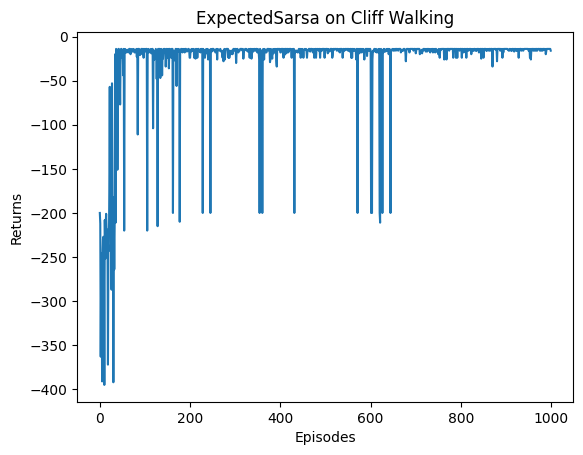

In [8]:
# env实例化
env = CliffWalkingEnv(render_mode='human', map_size=(4, 12), pix_square_size=30)
env.action_space.seed(42)  # 设置随机种子
state, info = env.reset(seed=42)  # 重置环境，返回初始状态和信息
wrapper_env = TimeLimit(env, max_episode_steps=200)  # 设置最大步数限制
wrapper_env = HashPosition(wrapper_env)  # 使用哈希位置包装器将二维状态转化为一维状态


# ExpectedSarsa实例化
epsilon = 0.1           # 初始探索率
alpha = 0.1             # 初始学习率
agent = ExpectedSarsa(wrapper_env, alpha=alpha, gamma=0.9, epsilon=epsilon, seed=42)  # 创建ExpectedSarsa智能体

num_episodes = 1000  # 设置训练的总回合数
num_period = 100  # 设置轮数
#  ExpectedSARSA 算法本身内部有折扣因子 γ,γ 的影响体现在 Q 表的更新中；
return_list = []  # 用于存储每个周期的平均回报,回报G_t(G_t = r_t +r_{t+1} + ... +r_T)

 # 分轮完成训练，每轮结束后统计该轮平均回报 
for i in range(num_period):
    # # tqdm的进度条功能
    with tqdm(total = num_episodes / num_period, desc='Iteration %d' % i) as pbar:
        for episode in range(int(num_episodes / num_period)):
            # 重置环境
            episode_return = 0
            state, _ = wrapper_env.reset() # _表示不关心info的值
            action  = agent.take_action(state)  # 选择动作
            wrapper_env.render(
                # → (ncol, nrow)	转为二维矩阵（先按列）,-1表示自动计算
                state_values = agent.V_table.reshape(-1,wrapper_env.nrow).T, 
                policy = agent.greedy_policy  # 渲染策略
                )  # 渲染环境
            while True:
                next_state, reward, terminated, truncated, info = wrapper_env.step(action)  # 执行动作
                # 掉下悬崖或者到达终点，正常走
                next_action = 0 if terminated or truncated else agent.take_action(next_state)  # 选择下一个动作
                # 更新Q_table
                agent.update_Q_table(state, action, reward, next_state, 5)
                # 更新策略，贪婪策略
                agent.update_policy()
                # 更新状态价值
                agent.update_V_table()
                # 更新回报（注意非折扣）
                episode_return += reward
                # 若掉下悬崖或者到达终点，结束当前回合
                if terminated or truncated:
                    episode_return += reward
                    break
                # 更新状态和动作
                state = next_state
                action = next_action
            # 降低渲染频率，提高运算速度
            if episode % 5 == 0:
                wrapper_env.render(
                    # → (ncol, nrow)	转为二维矩阵（先按列）,-1表示自动计算
                    state_values = agent.V_table.reshape(-1,wrapper_env.nrow).T, 
                    policy = agent.greedy_policy  # 渲染策略
                    )
            return_list.append(episode_return)  # 记录回报
            if (episode + 1) % 5 == 0:  # 每10条序列打印一下这10条序列的平均回报
                pbar.set_postfix({
                    'episode':
                    '%d' % (num_episodes / 10 * i + episode + 1),
                    'return':
                    '%.3f' % np.mean(return_list[-10:])
                })
            pbar.update(1)
    agent.epsilon = max(0.01, agent.epsilon * 0.99)
    agent.alpha = max(0.01, agent.alpha * 0.99)
wrapper_env.close()

# 绘制return变化图
episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('ExpectedSarsa on {}'.format('Cliff Walking'))
plt.show()

4. N-step SARSA(on-policy)进行训练（学习率和探索率动态调整）

Iteration 0: 100%|██████████| 10/10.0 [00:00<00:00, 14.80it/s, episode=10, return=-314.200]
Iteration 1: 100%|██████████| 10/10.0 [00:00<00:00, 18.90it/s, episode=110, return=-285.800]
Iteration 2: 100%|██████████| 10/10.0 [00:00<00:00, 18.17it/s, episode=210, return=-284.500]
Iteration 3: 100%|██████████| 10/10.0 [00:00<00:00, 17.82it/s, episode=310, return=-182.900]
Iteration 4: 100%|██████████| 10/10.0 [00:00<00:00, 23.74it/s, episode=410, return=-115.000]
Iteration 5: 100%|██████████| 10/10.0 [00:00<00:00, 24.74it/s, episode=510, return=-52.200]
Iteration 6: 100%|██████████| 10/10.0 [00:00<00:00, 24.32it/s, episode=610, return=-35.900]
Iteration 7: 100%|██████████| 10/10.0 [00:00<00:00, 22.36it/s, episode=710, return=-140.100]
Iteration 8: 100%|██████████| 10/10.0 [00:00<00:00, 24.85it/s, episode=810, return=-23.100]
Iteration 9: 100%|██████████| 10/10.0 [00:00<00:00, 24.73it/s, episode=910, return=-21.300]
Iteration 10: 100%|██████████| 10/10.0 [00:00<00:00, 25.39it/s, episode=101

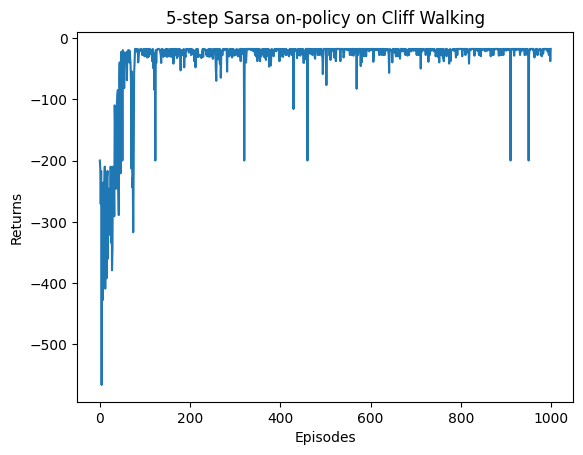

In [9]:
# env实例化
env = CliffWalkingEnv(render_mode='human', map_size=(4, 12), pix_square_size=30)
env.action_space.seed(50)  # 设置随机种子
state, info = env.reset(seed=50)  # 重置环境，返回初始状态和信息
wrapper_env = TimeLimit(env, max_episode_steps=200)  # 设置最大步数限制
wrapper_env = HashPosition(wrapper_env)  # 使用哈希位置包装器将二维状态转化为一维状态


# Nstep_SARSA实例化
epsilon = 0.1           # 初始探索率
alpha = 0.1             # 初始学习率
nstep = 5
agent = Nstep_SARSA(wrapper_env, alpha=alpha, gamma=0.9, epsilon=epsilon, seed=50, nstep=nstep)  # 创建Nstep_SARSA智能体

num_episodes = 1000  # 设置训练的总回合数
num_period = 100  # 设置轮数
#  Nstep_SARSA 算法本身内部有折扣因子 γ,γ 的影响体现在 Q 表的更新中；
return_list = []  # 用于存储每个周期的平均回报,回报G_t(G_t = r_t +r_{t+1} + ... +r_T)

 # 分轮完成训练，每轮结束后统计该轮平均回报 
for i in range(num_period):
    # # tqdm的进度条功能
    with tqdm(total = num_episodes / num_period, desc='Iteration %d' % i) as pbar:
        for episode in range(int(num_episodes / num_period)):
            # 重置环境
            episode_return = 0
            state, _ = wrapper_env.reset() # _表示不关心info的值
            action  = agent.take_action(state)  # 选择动作
            wrapper_env.render(
                # → (ncol, nrow)	转为二维矩阵（先按列）,-1表示自动计算
                state_values = agent.V_table.reshape(-1,wrapper_env.nrow).T, 
                policy = agent.greedy_policy  # 渲染策略
                )  # 渲染环境
            while True:
                next_state, reward, terminated, truncated, info = wrapper_env.step(action)  # 执行动作
                # 掉下悬崖或者到达终点，正常走
                next_action = 0 if terminated or truncated else agent.take_action(next_state)  # 选择下一个动作
                # 更新Q_table
                agent.update_Q_table(state, action, reward, next_state, next_action, done=(terminated or truncated))
                # 更新策略，贪婪策略
                agent.update_policy()
                # 更新状态价值
                agent.update_V_table()
                # 更新回报（注意非折扣）
                episode_return += reward
                # 若掉下悬崖或者到达终点，结束当前回合
                if terminated or truncated:
                    episode_return += reward
                    break
                # 更新状态和动作
                state = next_state
                action = next_action
            # 降低渲染频率，提高运算速度
            if episode % 5 == 0:
                wrapper_env.render(
                    # → (ncol, nrow)	转为二维矩阵（先按列）,-1表示自动计算
                    state_values = agent.V_table.reshape(-1,wrapper_env.nrow).T, 
                    policy = agent.greedy_policy  # 渲染策略
                    )
            return_list.append(episode_return)  # 记录回报
            if (episode + 1) % 5 == 0:  # 每10条序列打印一下这10条序列的平均回报
                pbar.set_postfix({
                    'episode':
                    '%d' % (num_episodes / 10 * i + episode + 1),
                    'return':
                    '%.3f' % np.mean(return_list[-10:])
                })
            pbar.update(1)
    agent.epsilon = max(0.01, agent.epsilon * 0.99)
    agent.alpha = max(0.01, agent.alpha * 0.99)
wrapper_env.close()

# 绘制return变化图
episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('{}-step Sarsa on-policy on {}'.format(nstep, 'Cliff Walking'))
plt.show()

4. N-step SARSA(off-policy)进行训练（学习率和探索率动态调整）

Iteration 0: 100%|██████████| 10/10.0 [00:00<00:00, 14.91it/s, episode=10, return=-324.000]
Iteration 1: 100%|██████████| 10/10.0 [00:00<00:00, 16.59it/s, episode=110, return=-318.600]
Iteration 2: 100%|██████████| 10/10.0 [00:00<00:00, 18.94it/s, episode=210, return=-196.100]
Iteration 3: 100%|██████████| 10/10.0 [00:00<00:00, 24.24it/s, episode=310, return=-103.900]
Iteration 4: 100%|██████████| 10/10.0 [00:00<00:00, 20.82it/s, episode=410, return=-171.000]
Iteration 5: 100%|██████████| 10/10.0 [00:00<00:00, 21.14it/s, episode=510, return=-153.300]
Iteration 6: 100%|██████████| 10/10.0 [00:00<00:00, 16.81it/s, episode=610, return=-208.300]
Iteration 7: 100%|██████████| 10/10.0 [00:00<00:00, 16.89it/s, episode=710, return=-144.800]
Iteration 8: 100%|██████████| 10/10.0 [00:00<00:00, 14.78it/s, episode=810, return=-216.800]
Iteration 9: 100%|██████████| 10/10.0 [00:00<00:00, 18.50it/s, episode=910, return=-193.600]
Iteration 10: 100%|██████████| 10/10.0 [00:00<00:00, 23.96it/s, episode

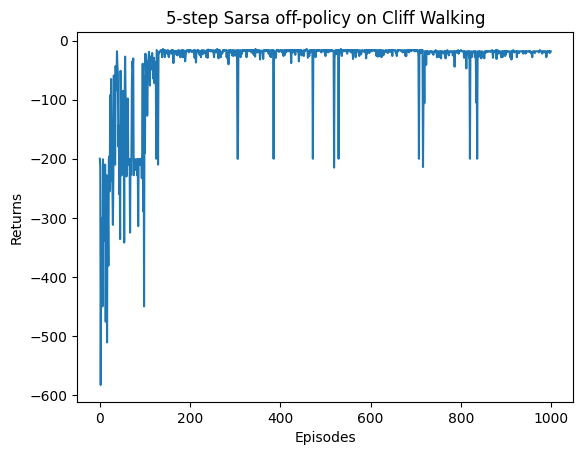

In [10]:
# env实例化
env = CliffWalkingEnv(render_mode='human', map_size=(4, 12), pix_square_size=30)
env.action_space.seed(50)  # 设置随机种子
state, info = env.reset(seed=50)  # 重置环境，返回初始状态和信息
wrapper_env = TimeLimit(env, max_episode_steps=200)  # 设置最大步数限制
wrapper_env = HashPosition(wrapper_env)  # 使用哈希位置包装器将二维状态转化为一维状态


# NstepSarsa(Off_policy)实例化
epsilon = 0.1           # 初始探索率
alpha = 0.1             # 初始学习率
nstep = 5
agent = NstepSarsa_Off_policy(wrapper_env, alpha=alpha, gamma=0.9, epsilon=epsilon, seed=50, nstep=nstep)  # 创建NstepSarsa(Off_policy)智能体

num_episodes = 1000  # 设置训练的总回合数
num_period = 100  # 设置轮数
#  NstepSarsa(Off_policy) 算法本身内部有折扣因子 γ,γ 的影响体现在 Q 表的更新中；
return_list = []  # 用于存储每个周期的平均回报,回报G_t(G_t = r_t +r_{t+1} + ... +r_T)

 # 分轮完成训练，每轮结束后统计该轮平均回报 
for i in range(num_period):
    # # tqdm的进度条功能
    with tqdm(total = num_episodes / num_period, desc='Iteration %d' % i) as pbar:
        for episode in range(int(num_episodes / num_period)):
            # 重置环境
            episode_return = 0
            state, _ = wrapper_env.reset() # _表示不关心info的值
            action  = agent.take_action(state)  # 选择动作
            wrapper_env.render(
                # → (ncol, nrow)	转为二维矩阵（先按列）,-1表示自动计算
                state_values = agent.V_table.reshape(-1,wrapper_env.nrow).T, 
                policy = agent.greedy_policy  # 渲染策略
                )  # 渲染环境
            while True:
                next_state, reward, terminated, truncated, info = wrapper_env.step(action)  # 执行动作
                # 掉下悬崖或者到达终点，正常走
                next_action = 0 if terminated or truncated else agent.take_action(next_state)  # 选择下一个动作
                # 更新Q_table
                agent.update_Q_table(state, action, reward, next_state, next_action, done=(terminated or truncated))
                # 更新策略，贪婪策略
                agent.update_policy()
                # 更新状态价值
                agent.update_V_table()
                # 更新回报（注意非折扣）
                episode_return += reward
                # 若掉下悬崖或者到达终点，结束当前回合
                if terminated or truncated:
                    episode_return += reward
                    break
                # 更新状态和动作
                state = next_state
                action = next_action
            # 降低渲染频率，提高运算速度
            if episode % 5 == 0:
                wrapper_env.render(
                    # → (ncol, nrow)	转为二维矩阵（先按列）,-1表示自动计算
                    state_values = agent.V_table.reshape(-1,wrapper_env.nrow).T, 
                    policy = agent.greedy_policy  # 渲染策略
                    )
            return_list.append(episode_return)  # 记录回报
            if (episode + 1) % 5 == 0:  # 每10条序列打印一下这10条序列的平均回报
                pbar.set_postfix({
                    'episode':
                    '%d' % (num_episodes / 10 * i + episode + 1),
                    'return':
                    '%.3f' % np.mean(return_list[-10:])
                })
            pbar.update(1)
    agent.epsilon = max(0.01, agent.epsilon * 0.99)
    agent.alpha = max(0.01, agent.alpha * 0.99)
wrapper_env.close()

# 绘制return变化图
episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('{}-step Sarsa off-policy on {}'.format(nstep, 'Cliff Walking'))
plt.show()

#### Q-Learning进行训练（学习率和探索率动态调整）

Iteration 0: 100%|██████████| 10/10.0 [00:00<00:00, 16.45it/s, episode=10, return=-272.300]
Iteration 1: 100%|██████████| 10/10.0 [00:00<00:00, 22.04it/s, episode=110, return=-241.700]
Iteration 2: 100%|██████████| 10/10.0 [00:00<00:00, 22.22it/s, episode=210, return=-184.400]
Iteration 3: 100%|██████████| 10/10.0 [00:00<00:00, 22.74it/s, episode=310, return=-148.900]
Iteration 4: 100%|██████████| 10/10.0 [00:00<00:00, 23.96it/s, episode=410, return=-163.400]
Iteration 5: 100%|██████████| 10/10.0 [00:00<00:00, 25.27it/s, episode=510, return=-137.600]
Iteration 6: 100%|██████████| 10/10.0 [00:00<00:00, 24.71it/s, episode=610, return=-131.900]
Iteration 7: 100%|██████████| 10/10.0 [00:00<00:00, 24.61it/s, episode=710, return=-112.900]
Iteration 8: 100%|██████████| 10/10.0 [00:00<00:00, 24.96it/s, episode=810, return=-109.400]
Iteration 9: 100%|██████████| 10/10.0 [00:00<00:00, 23.85it/s, episode=910, return=-83.100]
Iteration 10: 100%|██████████| 10/10.0 [00:00<00:00, 26.07it/s, episode=

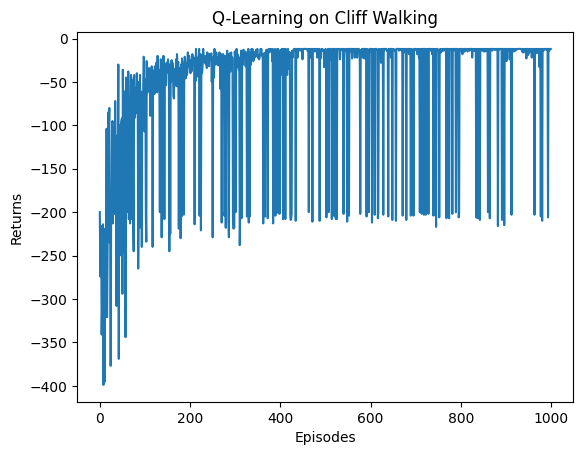

In [11]:
# env实例化
env = CliffWalkingEnv(render_mode='human', map_size=(4, 12), pix_square_size=30)
env.action_space.seed(50)  # 设置随机种子
state, info = env.reset(seed=50)  # 重置环境，返回初始状态和信息
wrapper_env = TimeLimit(env, max_episode_steps=200)  # 设置最大步数限制
wrapper_env = HashPosition(wrapper_env)  # 使用哈希位置包装器将二维状态转化为一维状态


# Q-Learning实例化
epsilon = 0.1           # 初始探索率
alpha = 0.1             # 初始学习率
agent = Q_learning(wrapper_env, alpha=alpha, gamma=0.9, epsilon=epsilon, seed=50)  # 创建Q-Learning智能体

num_episodes = 1000  # 设置训练的总回合数
num_period = 100  # 设置轮数
#  Q-Learning 算法本身内部有折扣因子 γ,γ 的影响体现在 Q 表的更新中；
return_list = []  # 用于存储每个周期的平均回报,回报G_t(G_t = r_t +r_{t+1} + ... +r_T)

 # 分轮完成训练，每轮结束后统计该轮平均回报 
for i in range(num_period):
    # # tqdm的进度条功能
    with tqdm(total = num_episodes / num_period, desc='Iteration %d' % i) as pbar:
        for episode in range(int(num_episodes / num_period)):
            # 重置环境
            episode_return = 0
            state, _ = wrapper_env.reset() # _表示不关心info的值
            action  = agent.take_action(state)  # 选择动作
            wrapper_env.render(
                # → (ncol, nrow)	转为二维矩阵（先按列）,-1表示自动计算
                state_values = agent.V_table.reshape(-1,wrapper_env.nrow).T, 
                policy = agent.greedy_policy  # 渲染策略
                )  # 渲染环境
            while True:
                next_state, reward, terminated, truncated, info = wrapper_env.step(action)  # 执行动作
                # 掉下悬崖或者到达终点，正常走
                next_action = 0 if terminated or truncated else agent.take_action(next_state)  # 选择下一个动作
                # 更新Q_table
                agent.update_Q_table(state, action, reward, next_state, 0)
                # 更新策略，贪婪策略
                agent.update_policy()
                # 更新状态价值
                agent.update_V_table()
                # 更新回报（注意非折扣）
                episode_return += reward
                # 若掉下悬崖或者到达终点，结束当前回合
                if terminated or truncated:
                    episode_return += reward
                    break
                # 更新状态和动作
                state = next_state
                action = next_action
            # 降低渲染频率，提高运算速度
            if episode % 5 == 0:
                wrapper_env.render(
                    # → (ncol, nrow)	转为二维矩阵（先按列）,-1表示自动计算
                    state_values = agent.V_table.reshape(-1,wrapper_env.nrow).T, 
                    policy = agent.greedy_policy  # 渲染策略
                    )
            return_list.append(episode_return)  # 记录回报
            if (episode + 1) % 5 == 0:  # 每10条序列打印一下这10条序列的平均回报
                pbar.set_postfix({
                    'episode':
                    '%d' % (num_episodes / 10 * i + episode + 1),
                    'return':
                    '%.3f' % np.mean(return_list[-10:])
                })
            pbar.update(1)
    agent.epsilon = max(0.01, agent.epsilon * 0.99)
    agent.alpha = max(0.01, agent.alpha * 0.99)
wrapper_env.close()

# 绘制return变化图
episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('Q-Learning on {}'.format('Cliff Walking'))
plt.show()